In [5]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [6]:
from dotenv import load_dotenv

load_dotenv()

True

## Messages

In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat models

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

result = llm.invoke(messages)

type(result)

langchain_core.messages.ai.AIMessage

In [9]:
result

AIMessage(content='One of the best places to see orcas in the United States is the Pacific Northwest, particularly around the San Juan Islands in Washington State. The waters surrounding these islands are home to a resident population of orcas, often referred to as the Southern Resident Killer Whales. The best time to see them is typically between late spring and early fall, with peak viewing months from May through September.\n\nSeveral tour operators offer whale-watching excursions from towns like Friday Harbor and Anacortes. Additionally, land-based viewing can be excellent from Lime Kiln Point State Park on San Juan Island, often called "Whale Watch Park" due to its popularity with both whales and watchers.\n\nAnother good location to see orcas is the Puget Sound area, including locations near Seattle, where transient orcas are often spotted. Always remember to follow responsible whale-watching guidelines to ensure the safety and preservation of these magnificent creatures.', addit

In [10]:
result.response_metadata

{'token_usage': {'completion_tokens': 182,
  'prompt_tokens': 67,
  'total_tokens': 249,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_5f20662549',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

In [11]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [12]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BhagcyqgNnysvnXOUpZviz6R', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 62, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e8dec97b-27be-467c-9536-46880cc814d5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_BhagcyqgNnysvnXOUpZviz6R', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 18, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [13]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_BhagcyqgNnysvnXOUpZviz6R',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

## Using messages as state

With these foundations in place, we can now use messages in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will will override the prior `messages` value.

As our graph runs, we want to **append** messages to to our `messages` state key.

We can use **[reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)** address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override* it as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [15]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built `MessagesState`!

`MessagesState` is defined:

+ With a pre-build single `messages` key
+ This is a list of `AnyMessage` objects
+ It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [16]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [17]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='50ecdaf1-5854-4729-b77a-b65d2abdef1f'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='b4ad82ba-b83c-472d-9594-aba0782ebb74'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='9b314e38-9bd4-4185-8f25-a91b3fbbe5ea')]

## Our graph

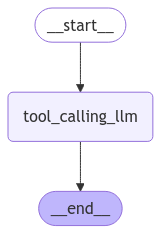

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


In [20]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4zdP59budJMmsDBLtgXeVFGB)
 Call ID: call_4zdP59budJMmsDBLtgXeVFGB
  Args:
    a: 2
    b: 3
